In [75]:
import sys
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
peps_file = 'out_triqler.tsv'

output_file = 'identified_peptides.tsv'

try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 34


In [77]:
#increase max limit to get larger files
ftplib.FTP.maxline = 100000

#get all peptides from the finished samples
peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    peps = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, peps_file), peps.append)
        df = pd.DataFrame(data=[x.split('\t') for x in peps[1::]], 
                          index=[sample for x in peps[1::]],
                          columns = peps[0].split('\t'))
        df['Sample'] = sample
    except ftplib.error_perm as e: #the search is not done yet!
        print('failed to extract all lines from {}, error:{}'.format(sample, e))
        continue #to next sample
    peps_df = pd.concat([peps_df, df])
    
print(peps_df.head(2))
avg = len(peps_df)/len(set(peps_df.index))

print('\nExtracted {} peptides from these {} Avg. Peptides per Sample: {}\n'.format(len(peps_df), len(set(peps_df.index)), avg))

failed to extract all lines from PXD005698-Sample-4, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-12, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-17, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-36, error:550 Failed to open file.
failed to extract all lines from PXD012255-Sample-1, error:550 Failed to open file.
                   run condition charge searchScore    intensity  \
PXD003209-Sample-1   1      HeLa      2     0.99381  2.888641e06   
PXD003209-Sample-1   2      HeLa      2     0.99381   2.69095e06   

                                       peptide  \
PXD003209-Sample-1  .(Gln->pyro-Glu)QAAEALDAAK   
PXD003209-Sample-1  .(Gln->pyro-Glu)QAAEALDAAK   

                                                             proteins  \
PXD003209-Sample-1  ENSP00000295463.3;altorf_ENST00000295463.4_3_c...   
PXD003209-Sample-1  ENSP00000295463.3;altorf_ENST00000295463.4_3_c...   

 

In [78]:
#close ftp connection
ftp.close()

In [79]:
peps_df.to_csv(output_file, sep='\t', index=False)

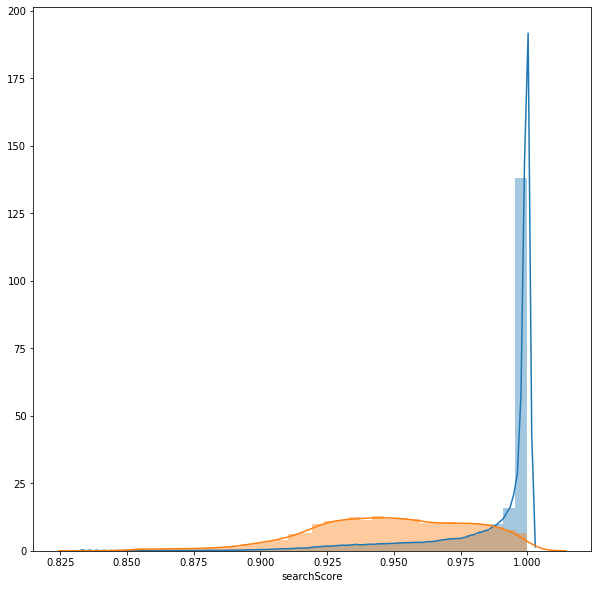

In [80]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

targets = peps_df.loc[peps_df.proteins.str.contains("DECOY") == False]
decoys = peps_df.loc[peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

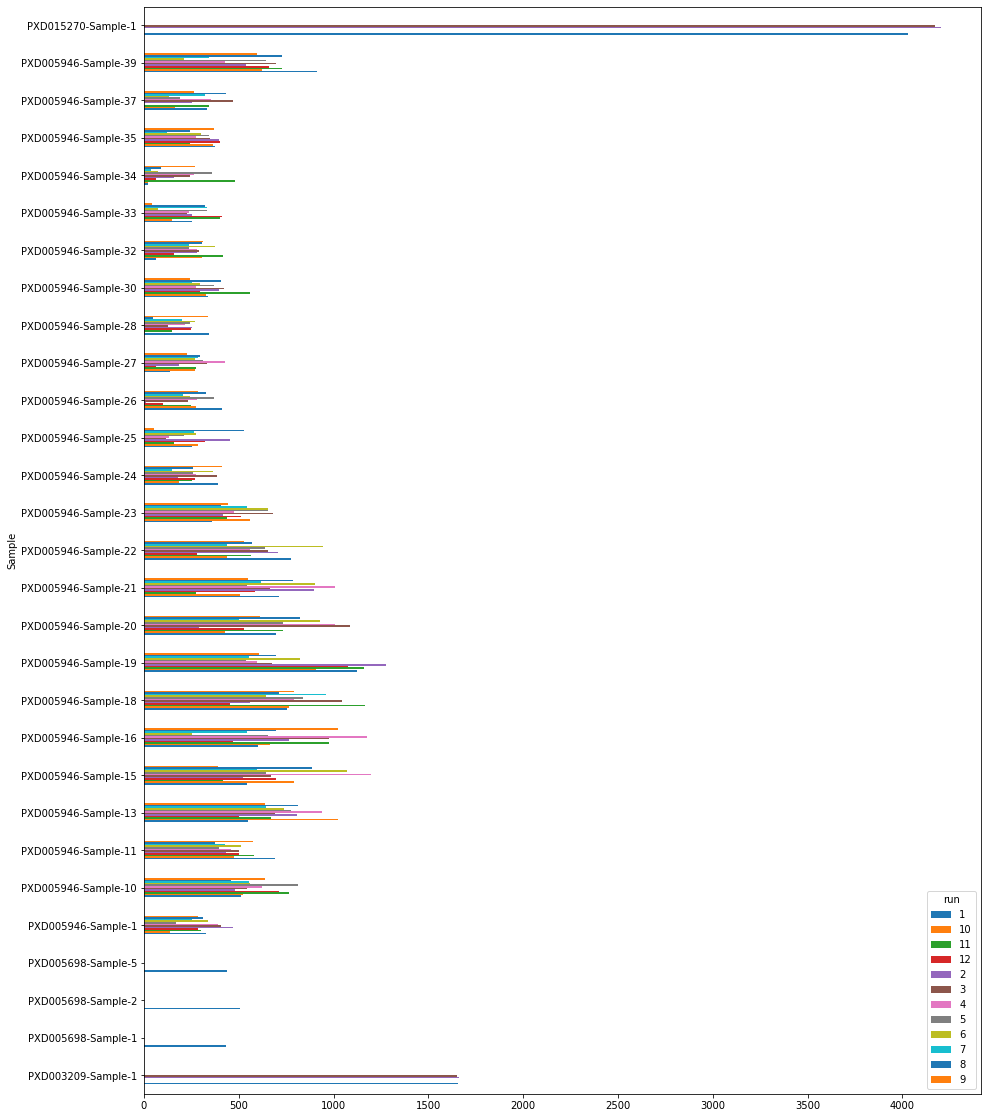

In [81]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()